In [1]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

#print(model.summary())

Using TensorFlow backend.


In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from numpy import float32

def plotImageAnalysis(imageLabels, firstImg, analyzedImages, sectionLabels, data):
    imageCols = len(imageLabels)

    fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 
    gs = fig.add_gridspec(3, imageCols)

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(sectionLabels[row-1], fontsize=16)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        # removes the white frame
        big_ax._frameon = False


    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(firstImg)
    ax1.set_title('Original Bild')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2 = fig.add_subplot(gs[1:imageCols])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.axis('off')
    ax2.set_title('Klassifizierungen')
    table = ax2.table(cellText=data[1:], colLabels=data[0], loc='center', cellLoc='left', colLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    for c in table.get_celld().values():
        c.visible_edges = 'horizontal'
        c.set_height(.11)

    for i in range(0,2*imageCols):
        ax = fig.add_subplot(3,imageCols,i+(imageCols+1))
        ax.set_title(imageLabels[i % imageCols])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(analyzedImages[i].astype(np.uint8))

    fig.set_facecolor('w')
    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from skimage.segmentation import mark_boundaries
import lime 
from lime import lime_image

def generateExplainerImages(inputImage, model, class_index, explainers):
    imgListResult = []
    imgAsArray = tf.keras.preprocessing.image.img_to_array(inputImage)
    for explainer in explainers:
        if 'Grad CAM' in explainer:
            data = ([imgAsArray], None)
            gradCamExplainer = GradCAM()
            imgListResult.append(
                gradCamExplainer.explain(class_index=class_index, model= model, layer_name= 'block5_conv3', validation_data= data)
            )
        elif 'Gradients Input' in explainer:
            data = (np.array([imgAsArray]), None)
            gradientsInputsExplainer = GradientsInputs()
            imgListResult.append(
                gradientsInputsExplainer.explain(data, model, class_index)
            )
        elif 'Occlusion Sensitivity' in explainer:
            data = ([imgAsArray], None)
            occlusionSensitivityExplainer = OcclusionSensitivity()
            imgListResult.append(
                occlusionSensitivityExplainer.explain(class_index=class_index, model= model, validation_data= data, patch_size=40)
            ) 
        elif 'LIME' in explainer:
            out = []
            x = np.expand_dims(imgAsArray, axis=0)
            x = preprocess_input(x)
            out.append(x)
            imagesStack = np.vstack(out)
            
            LimeExplainer = lime_image.LimeImageExplainer()
            explanation = LimeExplainer.explain_instance(imagesStack[0], model.predict, top_labels=1000, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(class_index, positive_only=True, num_features=5, hide_rest=True)
            imgListResult.append(mark_boundaries(temp / 2 + 0.5, mask))

    return imgListResult

In [4]:
def analyzeImage(imgPath, targetClass, explanationMethods):
    img = tf.keras.preprocessing.image.load_img(imgPath, target_size=(224, 224))
    imageArr = tf.keras.preprocessing.image.img_to_array(img)  #output Numpy-array

    imageReshaped = imageArr.reshape((1, imageArr.shape[0], imageArr.shape[1], imageArr.shape[2]))

    image = preprocess_input(imageReshaped)
    predictions = model.predict(imageReshaped)
    labels = decode_predictions(predictions, 1000)
    
    sortedPredictions = np.argsort(predictions)[0,::-1][:]
    
    data = [('Nummer', 'Klasse', 'Wahrscheinlichkeit')]

    firstPredictionsUntil = 5
    predictedClassIndex = sortedPredictions[0]
    targetClassIndex = 0
    for i, label in enumerate(labels[0]):
        if i < firstPredictionsUntil or label[1] == targetClass:
            data.append((i+1, label[1].replace('_', ' ').title(), "%.2f%%" % (label[2] * 100)))
        if label[1] == targetClass:
            targetClassIndex = sortedPredictions[i]

    sectionLabels = ['Übersicht\n']
    for sectionLabel, dataTuppel in zip(['Klassifikation %s %s\n','Klassifikation %s %s\n'], (data[1], data[-1])):
        sectionLabels.append(sectionLabel % (dataTuppel[1], dataTuppel[2]))

    explainedImages = generateExplainerImages(img, model, predictedClassIndex, explanationMethods)
    explainedImages.extend(generateExplainerImages(img, model, targetClassIndex, explanationMethods))

    plotImageAnalysis(explanationMethods, img, explainedImages, sectionLabels, data)

In [5]:
import os
def analyzeDirectory(directory, explanationMethods):
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                targetClass = entry.name.split('.')[0]
                filePath = directory + entry.name
                analyzeImage(filePath, targetClass, explanationMethods)

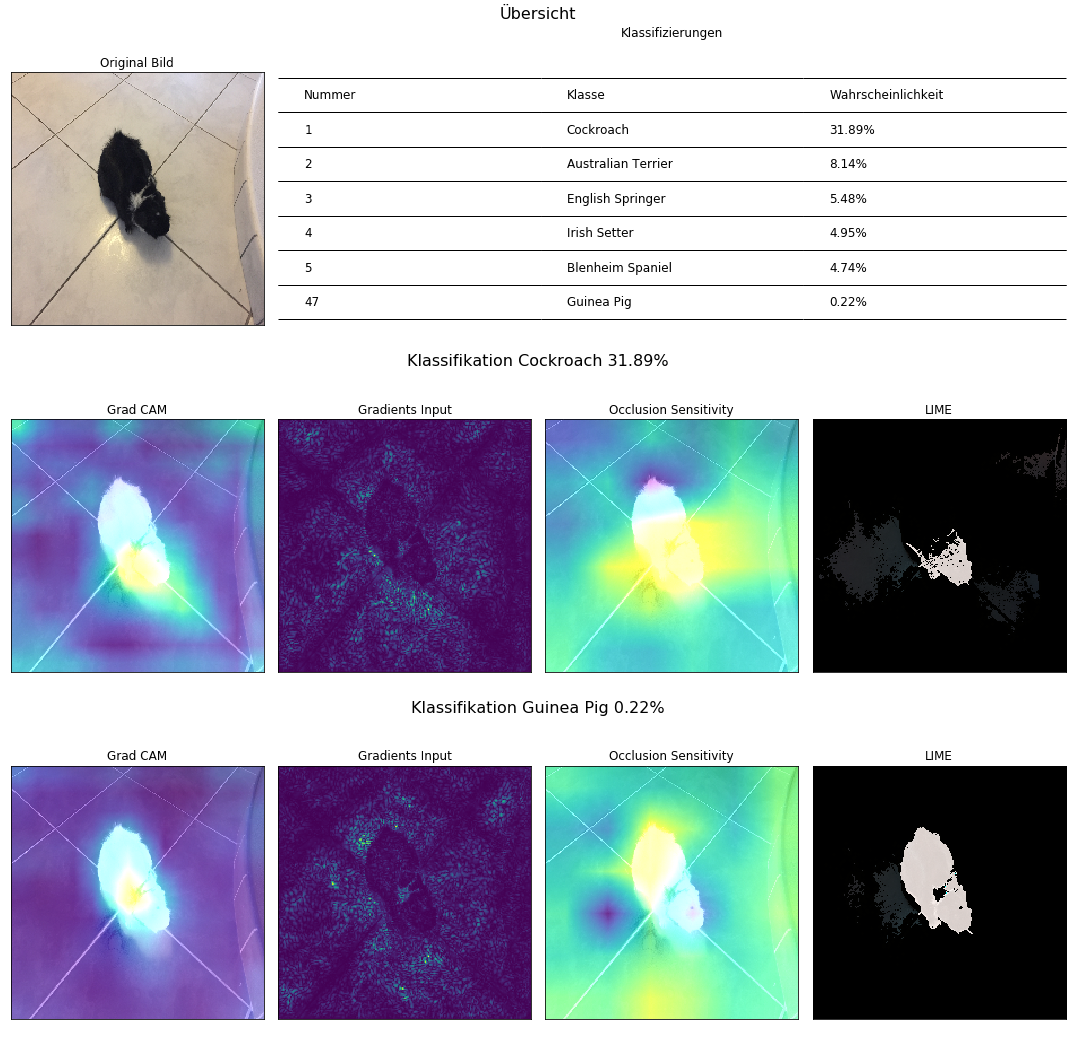

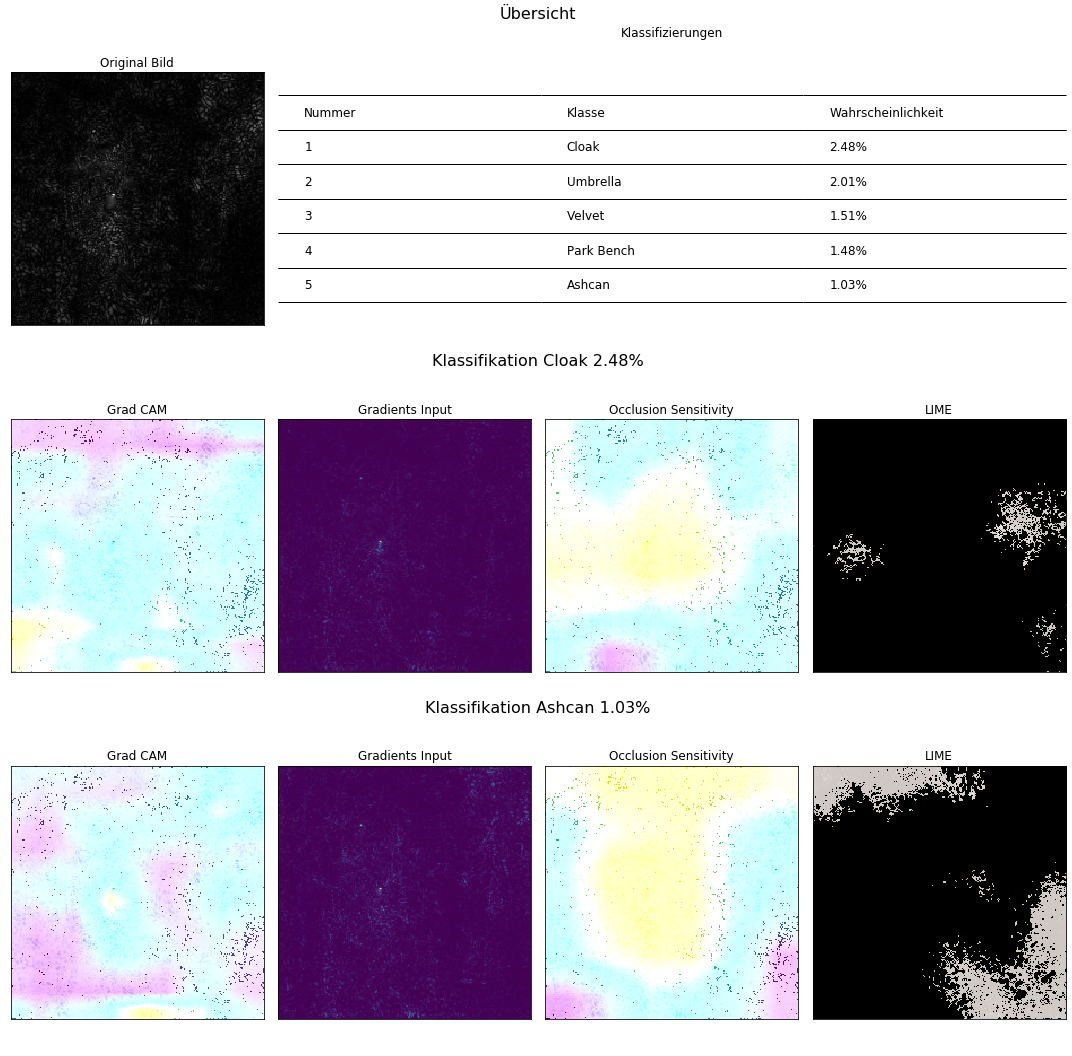

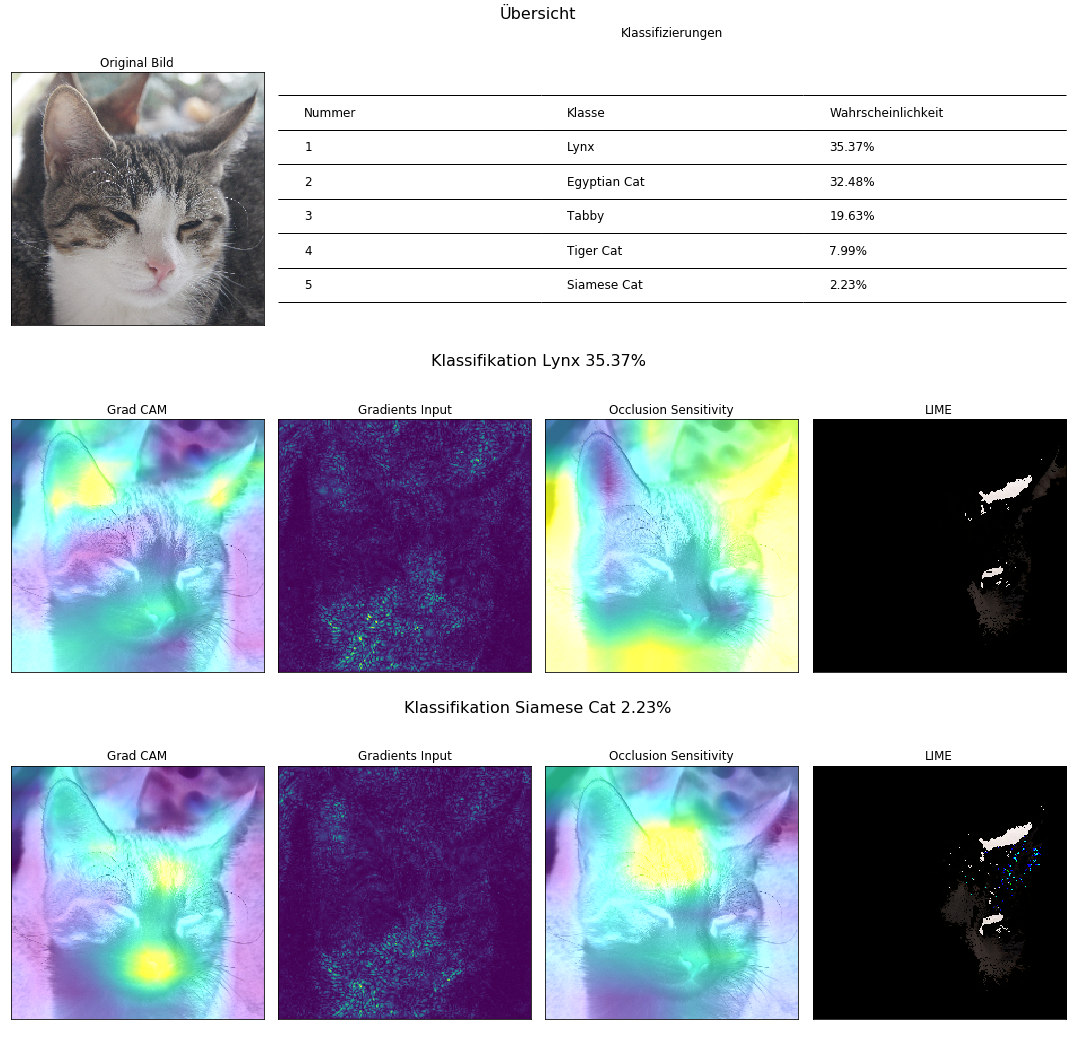

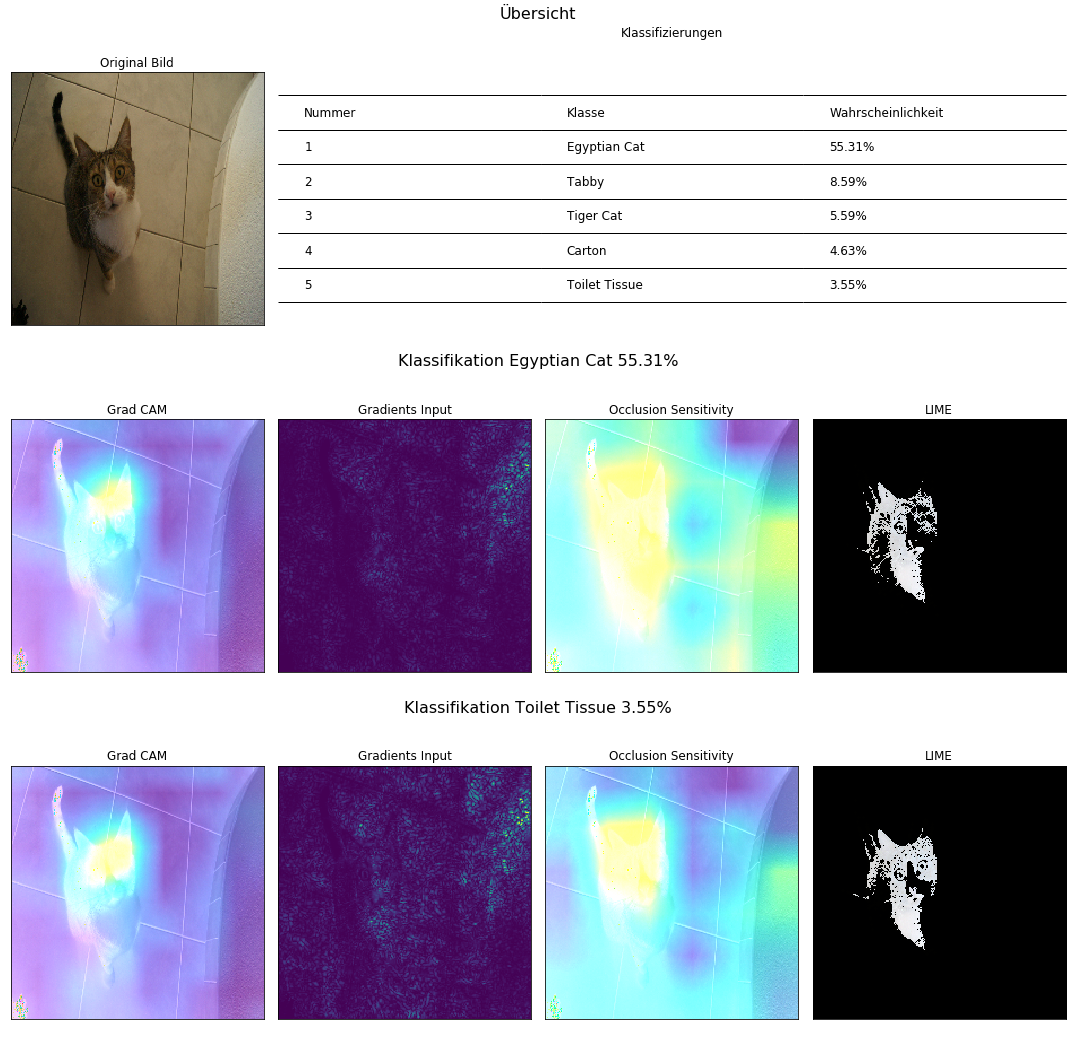

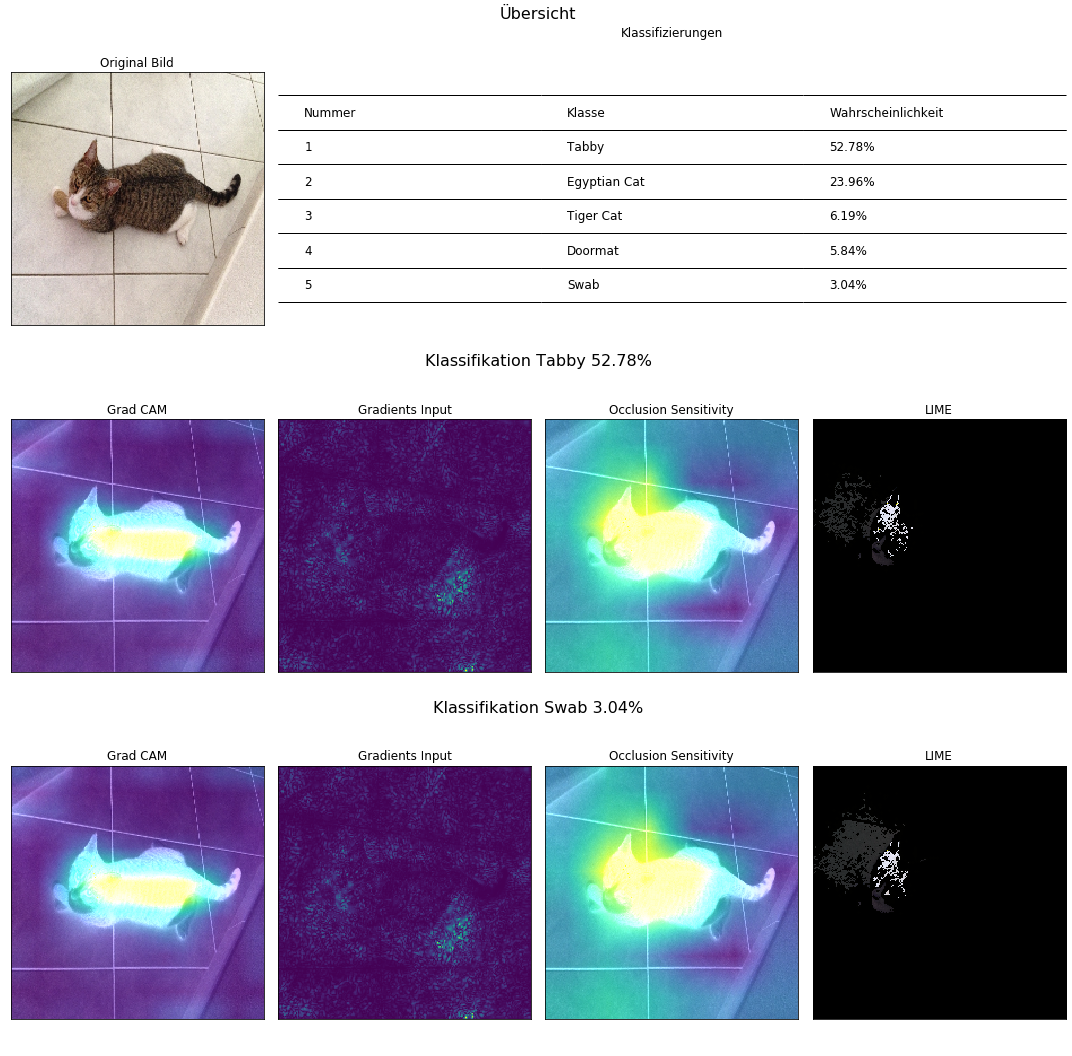

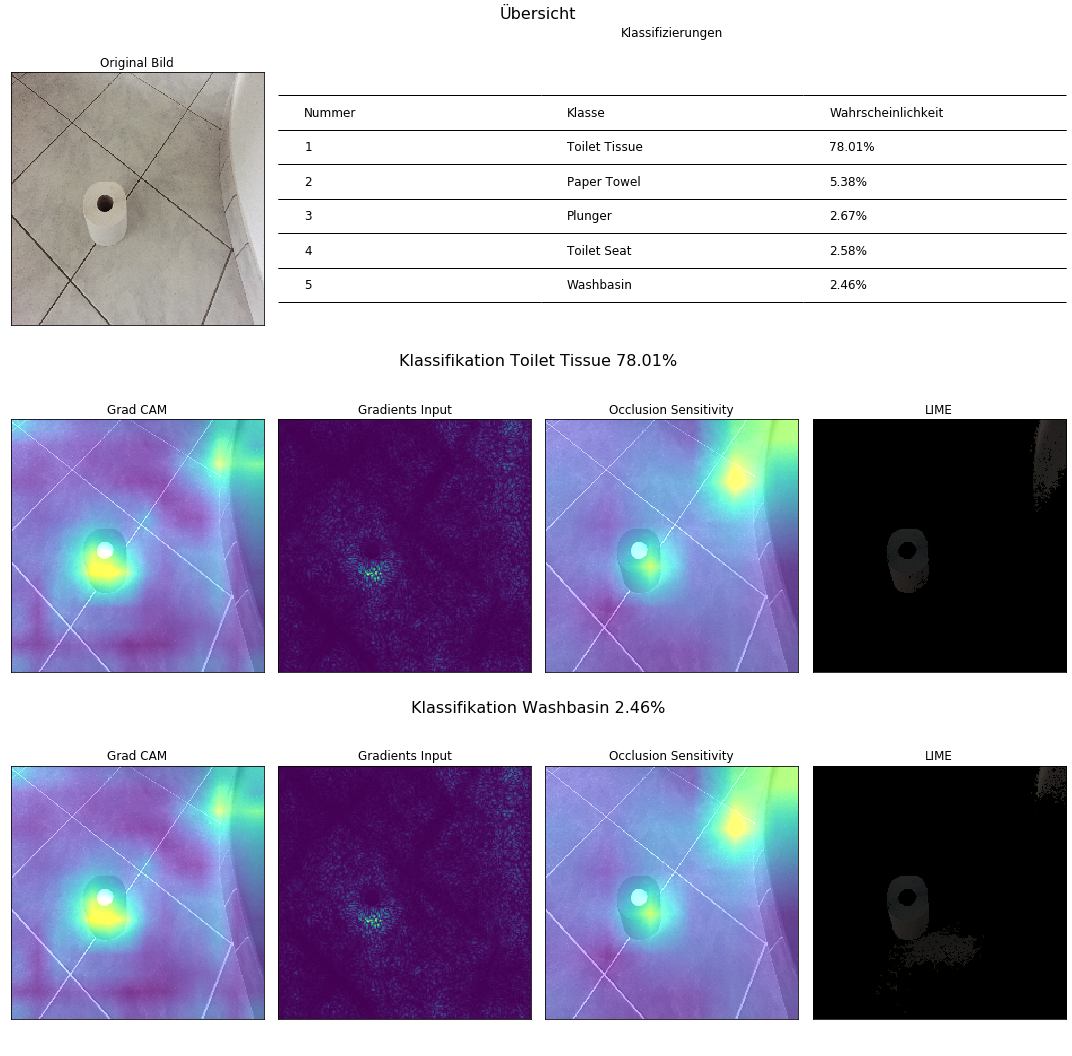

In [6]:
analyzeDirectory('D:/Master Thesis/Repo/Test Images/', explanationMethods = ['Grad CAM','Gradients Input','Occlusion Sensitivity','LIME'])

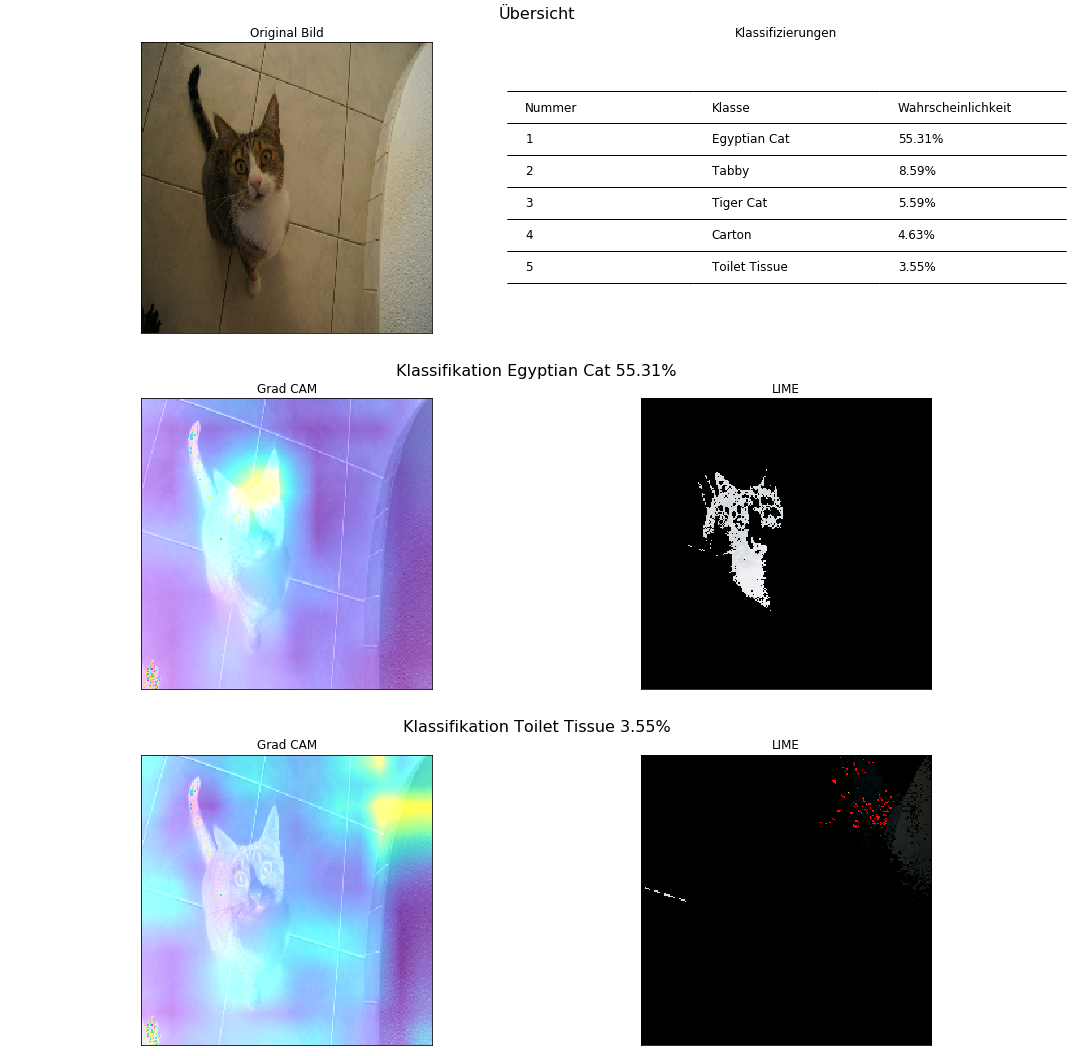

In [7]:
analyzeImage('D:/Master Thesis/Repo/Test Images/tabby.2.jpg', 'toilet_tissue', ['Grad CAM','LIME'])